In [1]:
import pandas as pd
import os, gc, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold

sys.path.append("../source/")
from helper_functions import *

In [ ]:
useID = False

dl = DataLoader()
df_tr = dl.load_csv("train_transaction.csv")
df_tr_test = dl.load_csv("test_transaction.csv")

if useID:
    dl.transaction = False
    df_id = dl.load_csv("train_identity.csv")
    df_id_test = dl.load_csv("test_identity.csv")

    df_train = df_tr.merge(df_id, how='left', left_index=True, right_index=True)

    fix = {o:n for o, n in zip(df_id_test.columns, df_id.columns)}
    df_id.rename(columns=fix, inplace=True)
    df_test = df_tr_test.merge(df_id, how='left', left_index=True, right_index=True)

    del df_id, df_id_test, df_train, df_tr_test

else:
    df_train = df_tr
    df_test = df_tr_test
    del df_tr, df_tr_test

gc.collect()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 395 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(6)
memory usage: 863.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 394 entries, TransactionID to TransactionDay
dtypes: bool(9), float32(377), int16(1), int32(2), int8(5)
memory usage: 740.3 MB


0

In [ ]:
#Adversarial Validation

def AdversarialValidation(df_train, df_test, columns_to_remove=[]):
    # Adversarial training to identify feautres which trivally pick out clients
    df_train["isTest"] = 0
    df_test["isTest"] = 1

    df_mixed = pd.concat([df_train, df_test], axis=0)
    df_mixed = df_mixed.drop(columns=columns_to_remove)
    df_mixed = df_mixed.sample(frac=1) #shuffle

    df_mixed = df_mixed.drop(["isFraud"], axis=1)
    df_mixed = df_mixed.drop(["TransactionID"], axis=1)

    # our XGBoost parameters
    params = {"device":"cuda", "objective":"binary:logistic",
                "eval_metric":"logloss",
                'learning_rate': 0.05,
                'max_depth': 5, }

    importance_df = pd.DataFrame()

    y = df_mixed['isTest']
    X = df_mixed.drop(['isTest'], axis=1)

    kf = KFold(n_splits=5)
    feature_importances = []
    auc_list = []

    for train_idx, val_idx in kf.split(X):
        dtrain = xgb.DMatrix(X.iloc[train_idx], label=y.iloc[train_idx], enable_categorical=True) #enable categorical requires df columns be astype("categorical")
        dval = xgb.DMatrix(X.iloc[val_idx], label=y.iloc[val_idx], enable_categorical=True)

        model = xgb.train(params, dtrain, num_boost_round=100)
        importance = model.get_score(importance_type='weight')
        feature_importances.append(importance)
        y_prob = model.predict(dval)
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[val_idx].astype(int).values, y_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)


    df_importances = pd.DataFrame(feature_importances)#.fillna(0)
    avg_importance = df_importances.mean(axis=0)
    avg_importance = avg_importance.sort_values(ascending=False)
    avg_auc = np.mean(auc_list)

    return avg_auc, avg_importance

# columns = ["V"+str(n) for n in range(1,337)] + ["TransactionDT", "TransactionDay", "card6", "D1", "D1", "D3", "D5", "D10", "R_emaildomain", "D9", "D11", "P_emaildomain"]
# auc, avg_importance = AdversarialValidation(df_tr, df_tr_test, columns)
# avg_importance.plot.barh()

In [ ]:
def encode_AG(aggregate_cols:list, groupby:list, aggregations=['mean', 'std'], train_df=df_train, test_df=df_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in aggregate_cols:  
        for col in groupby:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

In [13]:
df_tr['D1n'] = np.floor(df_tr["TransactionDay"] - df_tr["D1"])
df_tr['uid'] = df_tr["card5"].astype(str)+'_'+df_tr["addr1"].astype(str)+'_'+df_tr["D1n"].astype(str)
df_tr = df_tr.copy()
# encode_AG(['D4n','D10n','D15n'],['uid'],['mean','std'])
# encode_AG(['TransactionAmt','dist1'],['uid'],['mean','std'])
# encode_AG(['C13'], ['uid'],['nunique'])



/tmp/ipykernel_24284/2984792523.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tr['D1n'] = np.floor(df_tr["TransactionDay"] - df_tr["D1"])
/tmp/ipykernel_24284/2984792523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tr['uid'] = df_tr["card5"].astype(str)+'_'+df_tr["addr1"].astype(str)+'_'+df_tr["D1n"].astype(str)


## Transaction Table
IP, ISP, Proxy, UA, browser, os, etc.associated with the transactions. Field names are masked for privacy

**Cateogorical features**: DeviceType, DeviceInfo, id_12-id_38

In [4]:
# we see that id_31 is a string with formatting browser + version + OS (sometimes)
# Let's extract the version and browser to use as separate variables
pattern = r'^(.*?)(\d+(?:\.\d+)*)(.*)$'
df_id[['browser', 'version', 'platform']] = df_id['id_31'].str.extract(pattern, expand=True)

# Now let's get all of those that don't include a version number
pattern = r'^([^0-9]*)$'
df_tmp = pd.DataFrame()
df_tmp["browser"] = df_id['id_31'].str.extract(pattern, expand=True)
df_tmp.dropna(inplace=True)

# add these back into the original dataframe
df_id.loc[df_id["browser"].isnull(), "browser"] = df_tmp

# drop the old column
df_id.drop("id_31", inplace=True, axis=1)

In [5]:
# let's see which rows contain useful data
for col in df_id.columns:
    pass
    print( (len(df_id) - df_id[col].isna().sum()) / len(df_id) *100, f" % of rows contain values for {col}")

# We should throw out anything that is sparesely populated or replace NaN with dummy values

100.0  % of rows contain values for TransactionID
100.0  % of rows contain values for id_01
97.66974270797945  % of rows contain values for id_02
45.983928781901504  % of rows contain values for id_03
45.983928781901504  % of rows contain values for id_04
94.8915990099353  % of rows contain values for id_05
94.8915990099353  % of rows contain values for id_06
3.5740780542594273  % of rows contain values for id_07
3.5740780542594273  % of rows contain values for id_08
51.94788987263663  % of rows contain values for id_09
51.94788987263663  % of rows contain values for id_10
97.74323490463348  % of rows contain values for id_11
100.0  % of rows contain values for id_12
88.27383469802334  % of rows contain values for id_13
55.49631499032815  % of rows contain values for id_14
97.74808816290307  % of rows contain values for id_15
89.67434637010948  % of rows contain values for id_16
96.62767882523417  % of rows contain values for id_17
31.27786290238711  % of rows contain values for id_18


TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
TransactionAMT: transaction payment amount in USD

ProductCD: product code, the product for each transaction

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address

dist: distance

P_ and (R__) emaildomain: purchaser and recipient email domain

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
ProductCD, 
P_emaildomain, 
R_emaildomain, 
M1 - M9

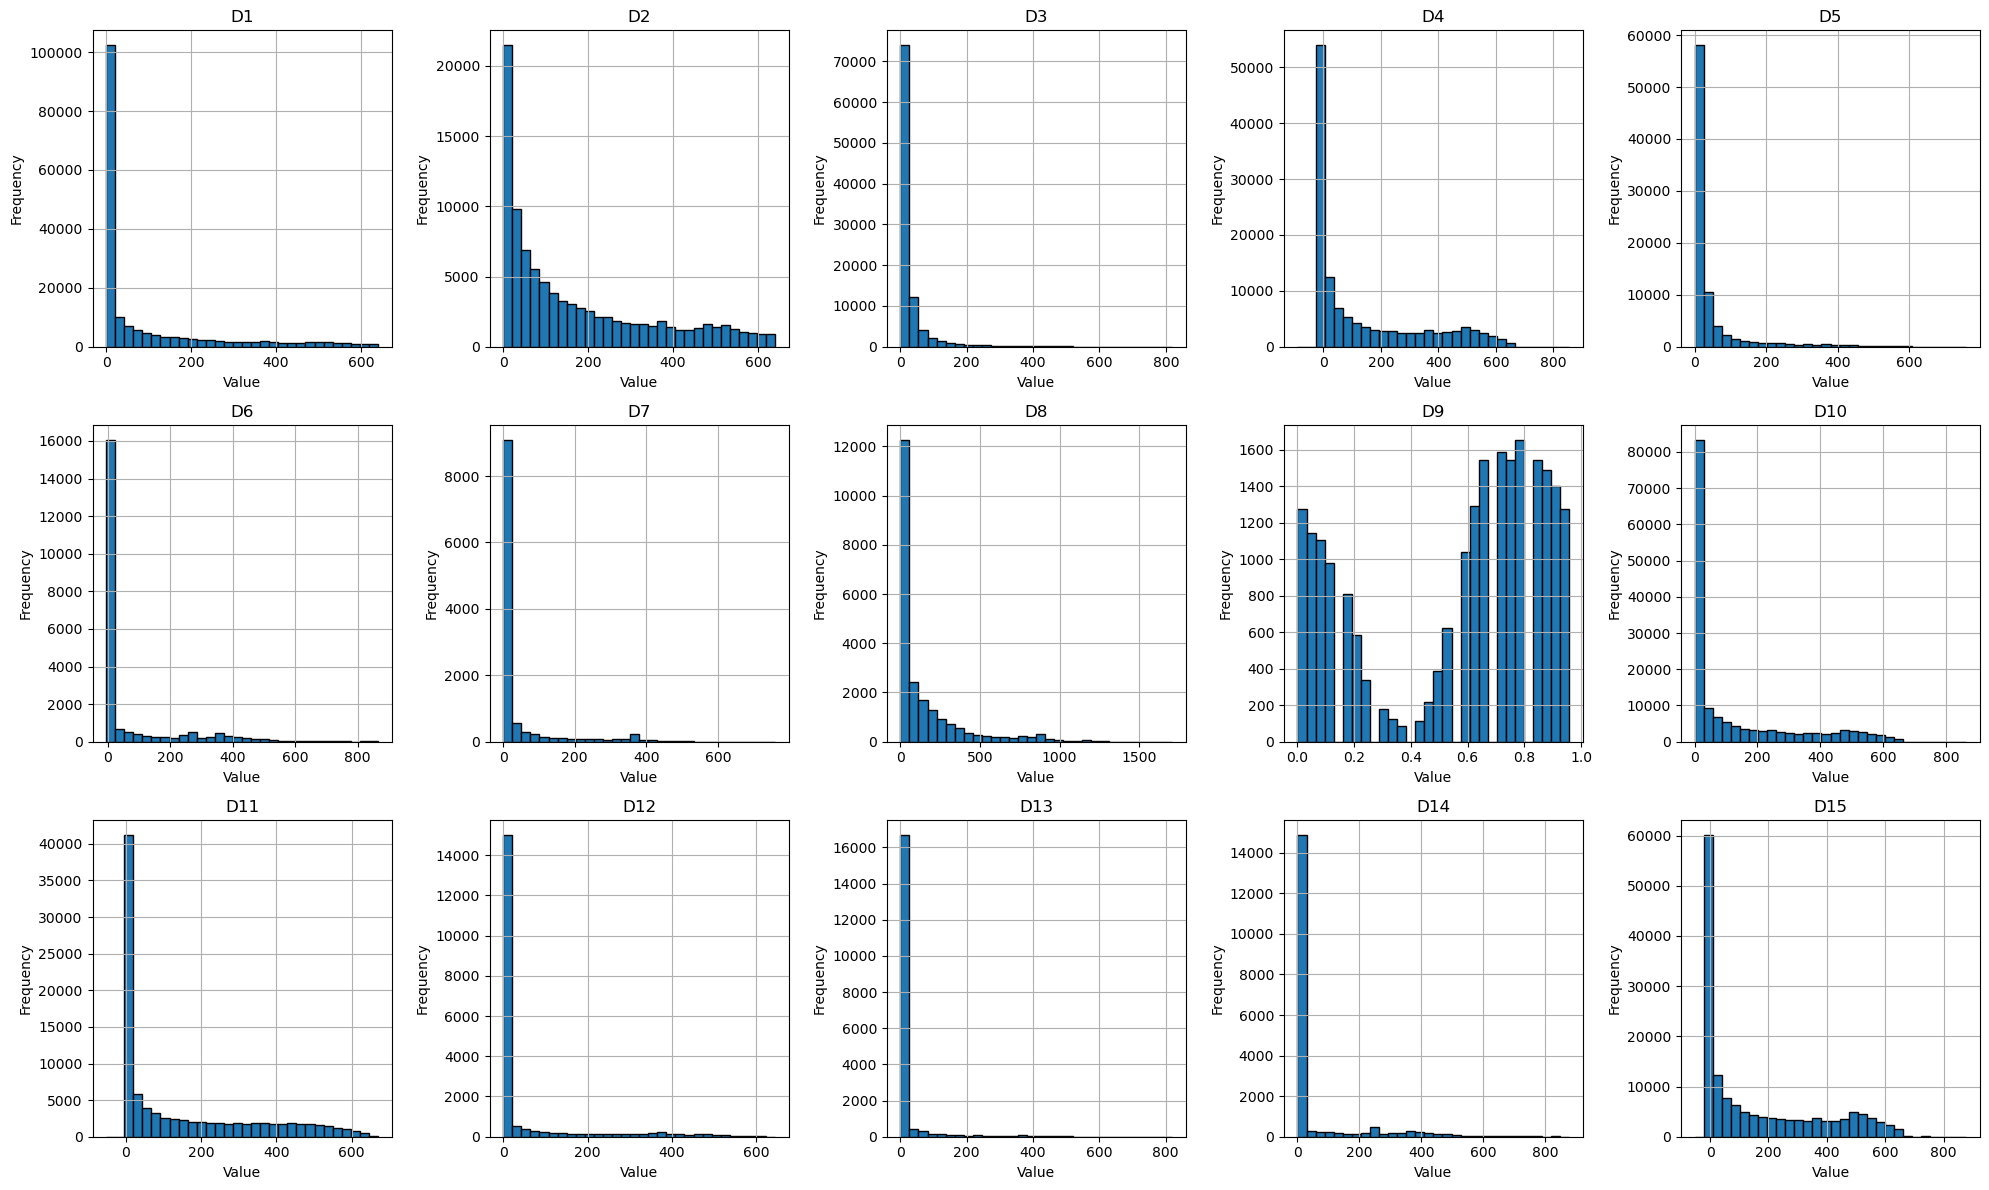

In [7]:
# Filter just the D1-D15 columns
d_columns = [f'D{i}' for i in range(1, 16)]
df = df_tr[d_columns]  # replace `df` with your actual DataFrame

# Set up the grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
axes = axes.flatten()  # flatten to easily iterate over

# Plot histograms
for i, col in enumerate(d_columns):
    # Create new variables while we are at it
    new_var_name = col+"n"
    df_tr[new_var_name] = df_tr["TransactionDay"] - df_tr[col]
    df[col].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Tight layout
plt.tight_layout()
plt.show()

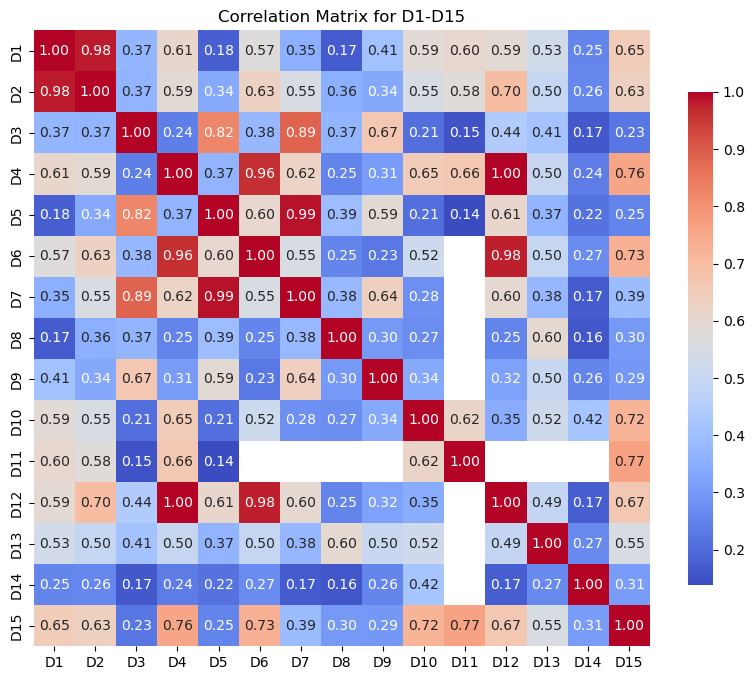

In [3]:
def draw_corr_matrix(var_prefix:str, first:int, last:int):
    d_columns = [f'{var_prefix}{i}' for i in range(first, last)]
    df = df_tr[d_columns]
    
    # Compute the correlation matrix
    corr_matrix = df.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix for D1-D15')
    plt.show()

draw_corr_matrix("D",1,16)

In [4]:
df =  pd.concat([df_tr, df_tr_test], axis=0)

In [19]:
target_col = 'isFraud'
input_cols =  [f'D{i}' for i in range(1, 16)]


# Step 1: Compute correlation matrix for input features
corr_matrix = df_train[input_cols].corr().abs()

# Step 2: Mask upper triangle and self-correlations
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = corr_matrix.where(upper).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]

# Step 3: Determine which column in each pair to drop
to_drop = set()
for col1, col2 in high_corr_pairs.index:
    corr1 = abs(df_train[[col1, target_col]].corr().iloc[0, 1])
    corr2 = abs(df_train[[col2, target_col]].corr().iloc[0, 1])
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)

# Step 4: Drop selected columns
df_train = df_train.drop(columns=list(to_drop))

KeyError: "['D1', 'D4', 'D5', 'D8', 'D9', 'D12'] not in index"

In [21]:
target_col = 'isFraud'
input_cols =  [f'C{i}' for i in range(1, 6)]


# Step 1: Compute correlation matrix for input features
corr_matrix = df_train[input_cols].corr().abs()

# Step 2: Mask upper triangle and self-correlations
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
high_corr_pairs = corr_matrix.where(upper).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.95]

# Step 3: Determine which column in each pair to drop
to_drop = set()
for col1, col2 in high_corr_pairs.index:
    corr1 = abs(df_train[[col1, target_col]].corr().iloc[0, 1])
    corr2 = abs(df_train[[col2, target_col]].corr().iloc[0, 1])
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)

# Step 4: Drop selected columns
df_train = df_train.drop(columns=list(to_drop))

In [11]:
# Find correlations with fraud
corr_fraud = df_tr.corrwith(df_tr["isFraud"], numeric_only=True)

# Find least correlated variables
corr_fraud = np.abs(corr_fraud).sort_values(ascending=True)

/home/alex/miniconda3/envs/fraudsters/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/alex/miniconda3/envs/fraudsters/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [5]:
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_train.columns:
    total_nan = int(df_train[col].isna().sum())
    percent_pop = (len(df_train) - df_train[col].isna().sum()) / len(df_train) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not total_nan in col_dict.keys():
        col_dict[total_nan] = []

    col_dict[total_nan].append(col)
    # print( percent_pop, f" % of rows contain values for {col}")

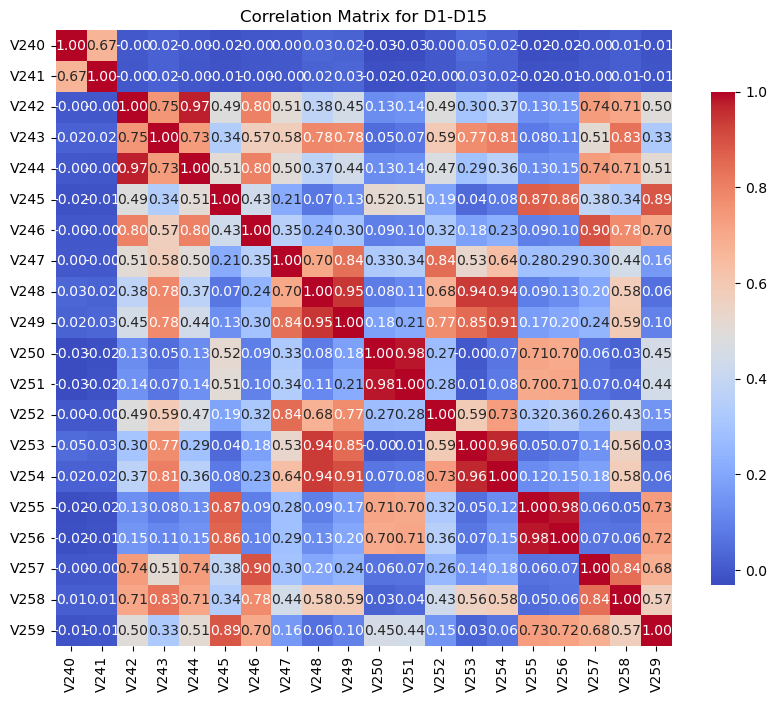

In [ ]:
draw_corr_matrix("V",240,260)

In [14]:
# Look at correlation between variables which are sparsely populated
"""
Many variables are sparsley populated. And many appear to be sparsley populated in the same way.
For variables which are sparsley populated in the same way, find out which ones are correlated with each other.
Of the ones which are highly correlated, only keep the one which is most highly correlated with isFraud.
Alternatively: Only keep the one which  has the most unique values
"""
# Organize columns which are equally sparsley populated
cols = []
col_dict = {}
for col in df_train.columns:
    total_nan = int(df_train[col].isna().sum())
    percent_pop = (len(df_train) - df_train[col].isna().sum()) / len(df_train) *100 # percent of rows which are not NaN
    percent_pop = round(percent_pop, 2)
    
    if not percent_pop in col_dict.keys():
        col_dict[percent_pop] = []

    col_dict[percent_pop].append(col)
    # print( percent_pop, f" % of rows contain values for {col}")
    
vars_to_keep = []
for percent in col_dict.keys():
    if percent < 50 and len(col_dict[percent]) > 1:
        corr_sparse = df_train[col_dict[percent]].corr(numeric_only=True)    

        strong_corr = corr_sparse.where((corr_sparse.abs() > 0.75) & (corr_sparse.abs() < 1.0))
        # Do we want to keep sparsley popoulated variables if they aren't correlated with other variables?
        # nan_columns = strong_corr.columns[strong_corr.isna().all()]
        # vars_to_keep += list(nan_columns)
        
        strong_corr_pairs = strong_corr.stack().reset_index()
        strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
        if len(strong_corr_pairs) == 0: continue
        # remove duplicate pairs
        strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Variable 1'] < strong_corr_pairs['Variable 2']]
        
        # Find variable most highly correlated with isFraud
        vars_with_strong_corr = pd.unique(
            strong_corr_pairs[['Variable 1', 'Variable 2']].values.ravel()
        )

        ## Keep the variable that is most highy correlated with isFraud
        # corr_fraud = df_train[vars_with_strong_corr].corrwith(df_train["isFraud"], numeric_only=True).abs()
        # vars_to_keep.append(corr_fraud.idxmax())

        ## Alternatively, keep the variable with the most unique values
        # vars_to_keep.append(df_train[vars_with_strong_corr].nunique().idxmax())
        
        ## Or combine the two. Take the variable with the most unique values of the variables which are correlated with isFraud above some threshold
        corr_fraud = df_train[vars_with_strong_corr].corrwith(df_train["isFraud"], numeric_only=True).abs() > 0.25 # must be 0.25 correlated
        # select only true values from mask
        corr_fraud = corr_fraud[corr_fraud].index
        # If there are no variables passing the threshold then don't use them
        if len(corr_fraud) < 1:
            continue
            
        vars_to_keep.append(df_train[corr_fraud].nunique().idxmax())
    else:
        vars_to_keep += col_dict[percent]

df_train = df_train[vars_to_keep]

<Axes: >

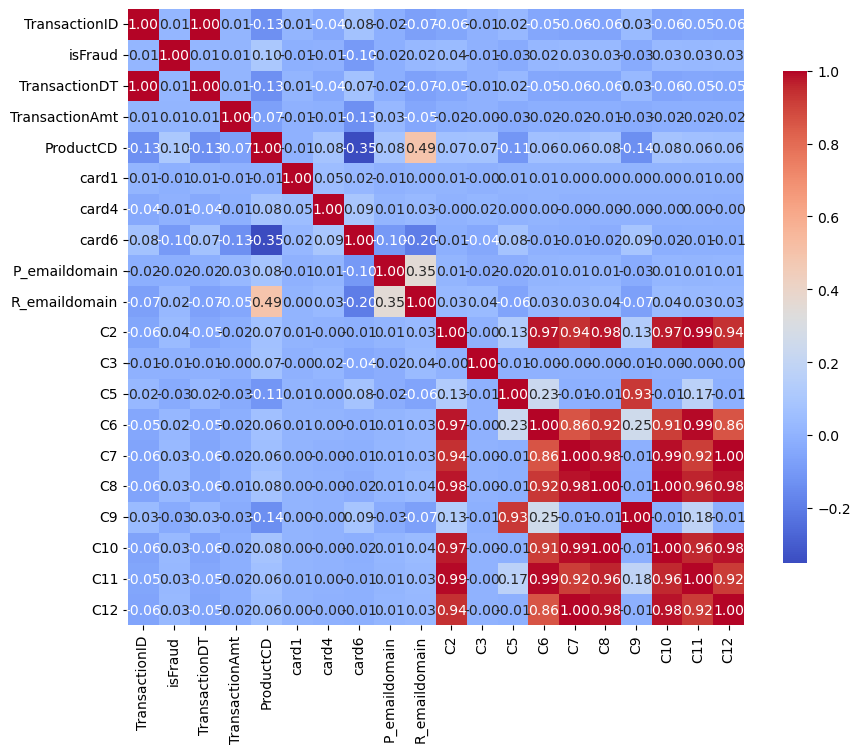

In [22]:
 # Compute the correlation matrix
corr_matrix = df_train.iloc[:,:20].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

In [8]:
for k in col_dict:
    if len(col_dict[k]) > 1:
        print(col_dict[k])

In [15]:
#df_tr_keep = df_tr[vars_to_keep]
# do we want to prune these even further?

In [16]:
#df_tr[["ProductCD", "card1","card2","card3","addr1", "addr2", "P_emaildomain", "R_emaildomain", "M1", "M2"]]

In [17]:
# Adversarial training to identify feautres which trivally pick out clients
df_tr["isTest"] = 0
df_tr_test["isTest"] = 1

df_mixed = pd.concat([df_tr, df_tr_test], axis=0)
df_mixed = df_mixed.sample(frac=1) #shuffle

df_mixed.drop(["isFraud"], axis=1)
# drop categorical variables at this point. Add them back after figuring out how to deal with them
# df_mixed.drop(categorical_vars,axis=1)

,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,...,D7n,D8n,D9n,D10n,D11n,D12n,D13n,D14n,D15n,isTest
355685,4019234,30569900,50.000,NaN,NaN,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,353.818287,NaN,NaN,353.818287,353.818287,353.818287,1
453720,4117269,33174517,724.000,NaN,NaN,1.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,383.964317,-20.035683,NaN,NaN,NaN,337.964317,1
357270,4020819,30612180,160.500,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,354.307639,354.307639,NaN,NaN,NaN,354.307639,1
166659,3153659,3549791,39.000,7.0,NaN,2.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,-398.914456,-2.914456,NaN,NaN,NaN,-398.914456,0
351017,4014566,30406056,13.895,NaN,67.0,1.0,5.0,0.0,1.0,0.0,...,339.921944,NaN,NaN,351.921944,NaN,327.921944,351.921944,351.921944,339.921944,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35192,3698741,19589362,59.000,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,226.728727,226.728727,NaN,NaN,NaN,226.728727,1
248153,3911702,27032763,315.000,287.0,NaN,3.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,160.879201,223.879201,NaN,NaN,NaN,223.879201,1
474804,3461804,12265277,39.000,NaN,NaN,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,141.959225,-443.040775,NaN,NaN,NaN,-443.040775,0
322207,3985756,29455280,35.950,3.0,NaN,69.0,52.0,0.0,0.0,51.0,...,NaN,NaN,NaN,109.917593,94.917593,NaN,NaN,NaN,80.917593,1


In [21]:
#only use one set of variables
var_dict_keys = list(col_dict.keys())

# our XGBoost parameters
params = {"objective":"binary:logistic",
              "eval_metric":"logloss",
              'learning_rate': 0.05,
              'max_depth': 5, }

importance_df = pd.DataFrame()
for key in var_dict_keys:
    df_mixed_subset = df_mixed[col_dict[key] + ["isTest"]]

    # create our DMatrix (the XGBoost data structure)
    y = df_mixed_subset['isTest']
    X = df_mixed_subset.drop(['isTest'], axis=1)
    
    kf = KFold(n_splits=5)
    feature_importances = []
    auc_list = []

    for train_idx, val_idx in kf.split(X):
        dtrain = xgb.DMatrix(X.iloc[train_idx], label=y.iloc[train_idx], enable_categorical=True)
        dval = xgb.DMatrix(X.iloc[val_idx], label=y.iloc[val_idx], enable_categorical=True)

        model = xgb.train(params, dtrain, num_boost_round=100)
        importance = model.get_score(importance_type='weight')
        feature_importances.append(importance)
        y_prob = model.predict(dval)
        threshold = 0.5
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[val_idx].astype(int).values, y_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
    

    df_importances = pd.DataFrame(feature_importances)#.fillna(0)
    avg_importance = df_importances.mean(axis=0)
    avg_importance = avg_importance.sort_values(ascending=False)
    avg_auc = np.mean(auc_list)

    if avg_auc > 0.85:
        importance_df =  pd.concat([importance_df, avg_importance], axis=0)
    print("avg auc:", avg_auc)
    print(avg_importance)
    print()
    
    
    # perform cross validation with XGBoost
    # cross_val_results = xgb.cv(dtrain=XGBdata, params=params, 
    #                        nfold=5, metrics="auc", 
    #                        num_boost_round=200,early_stopping_rounds=20,
    #                        as_pandas=True)
    
    # # print out the final result
    # print((cross_val_results["test-auc-mean"]))
    


avg auc: 1.0
isFraud    100.0
dtype: float64

avg auc: 0.5215285846563061
dist1    1798.0
dtype: float64

avg auc: 0.5123260109218114
dist2    1836.2
dtype: float64

avg auc: 0.9999154993625453
D1n     794.2
D1      745.6
V282      2.0
dtype: float64

avg auc: 0.8895446748570084
D2     990.6
D2n    893.0
dtype: float64

avg auc: 0.910249568307329
D3n    749.6
D3     605.4
dtype: float64

avg auc: 0.9779953776557168
D4n    880.4
D4     868.2
dtype: float64

avg auc: 0.8835882717232966
D5n    795.2
D5     694.8
dtype: float64

avg auc: 0.6692295301089427
D6n    708.8
D6     636.6
dtype: float64

avg auc: 0.5880290979217786
D7n    661.2
D7     620.6
dtype: float64

avg auc: 0.6270349186731142
D8n    203.2
D9n    199.8
D8     165.0
D9      28.8
dtype: float64

avg auc: 0.9978314655293659
D10n    848.2
D10     720.2
dtype: float64

avg auc: 0.9176878909359484
D11     850.0
D11n    795.8
V6        2.0
V4        1.0
dtype: float64

avg auc: 0.615399212912088
D12n    669.6
D12     653.6
dtype:

<Axes: >

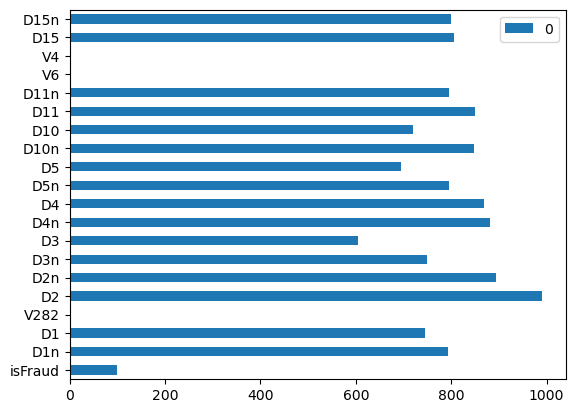

In [34]:
importance_df.plot.barh()

In [ ]:
importance_df